# Object masks from prompts with SAM

To run in Google Colab [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1A0LpGaDId6-7_okw47YXkqoXNoetHVp8)

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.


## Environment Set-up

In [1]:
import torch
import numpy as np
import IPython
import matplotlib.pyplot as plt
import cv2
import io
import PIL.Image as Image
import os
import sys
from torchvision.transforms import GaussianBlur
from tqdm import tqdm

IN_COLAB = 'google.colab' in sys.modules

In [2]:
print("CUDA is available:", torch.cuda.is_available())


!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install ipympl

sam_checkpoint = "sam_vit_h_4b8939.pth"
face_detection_model = "face_detection_yunet_2023mar.onnx"

if not os.path.isdir('models'):
  !mkdir models
# download SAM
  if not os.path.isfile(f'models/{sam_checkpoint}'):
    !wget https://dl.fbaipublicfiles.com/segment_anything/$sam_checkpoint
    !mv $sam_checkpoint models/

  # download YuNet Faec Detection Model
  if not os.path.isfile(f'models/{face_detection_model}'):
    !wget https://github.com/astaileyyoung/CineFace/raw/main/research/data/face_detection_yunet_2023mar.onnx
    !mv $face_detection_model models/

if not os.path.isdir('images/input_images'):
  !mkdir -p images/input_images

if not os.path.isdir('images/masks'):
  !mkdir -p images/masks

CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-yii9p16w
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-yii9p16w
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=8ec5648dcaeb6ce5a65d103896915077f67a96d42fbceafb2c420e341677f0a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-j3rfmuiy/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.1 MB/s eta 0:00:00
--2025-01-04 12:29:12--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.

## Program Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [3]:
def show_mask(mask, ax, random_color=False, display=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        # color to inpaint (white)
        color = np.array([255, 255, 255])

    # color to keep intact (black)
    background_color = np.array([0, 0, 0])
    h, w = mask.shape[-2:]

    # Reshape the mask to have the same number of color channels
    mask = mask.reshape(h, w, 1)

    # Apply color to the mask where mask is True, and color2 where mask is False
    mask_image = mask * color.reshape(1, 1, -1) + ~mask * background_color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [4]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=f'models/{sam_checkpoint}')
sam.to(device=device)

predictor = SamPredictor(sam)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Face detector class, `FaceDetectorYuNet()`, is constructed.

In [5]:
class FaceDetectorYunet():
    def __init__(self,
                  model_path='models/face_detection_yunet_2023mar.onnx',
                  img_size=(300, 300),
                  threshold=0.5):
        self.model_path = model_path
        self.img_size = img_size
        self.fd = cv2.FaceDetectorYN_create(str(model_path),
                                            "",
                                            img_size,
                                            score_threshold=threshold)

    def draw_faces(self,
                   image,
                   faces,
                   show_confidence=False):
        for face in faces:
            color = (0, 0, 255)
            thickness = 2
            cv2.rectangle(image, (face['x1'], face['y1']), (face['x2'], face['y2']), color, thickness, cv2.LINE_AA)

            if show_confidence:
                confidence = face['confidence']
                confidence = "{:.2f}".format(confidence)
                position = (face['x1'], face['y1'] - 10)
                font = cv2.FONT_HERSHEY_SIMPLEX
                scale = 0.5
                thickness = 1
                cv2.putText(image, confidence, position, font, scale, color, thickness, cv2.LINE_AA)
        return image

    def scale_coords(self, image, prediction):
        ih, iw = image.shape[:2]
        rw, rh = self.img_size
        a = np.array([
                (prediction['x1'], prediction['y1']),
                (prediction['x1'] + prediction['x2'], prediction['y1'] + prediction['y2'])
                    ])
        b = np.array([iw/rw, ih/rh])
        c = a * b
        prediction['img_width'] = iw
        prediction['img_height'] = ih
        prediction['x1'] = int(c[0,0].round())
        prediction['x2'] = int(c[1,0].round())
        prediction['y1'] = int(c[0,1].round())
        prediction['y2'] = int(c[1,1].round())
        prediction['face_width'] = (c[1,0] - c[0,0])
        prediction['face_height'] = (c[1,1] - c[0,1])
        # prediction['face_width'] = prediction['x2'] - prediction['x1']
        # prediction['face_height'] = prediction['y2'] - prediction['y1']
        prediction['area'] = prediction['face_width'] * prediction['face_height']
        prediction['pct_of_frame'] = prediction['area']/(prediction['img_width'] * prediction['img_height'])
        return prediction

    def detect(self, image):
        if isinstance(image, str):
            image = cv2.imread(str(image))
        img = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        img = cv2.resize(img, self.img_size)
        self.fd.setInputSize(self.img_size)
        _, faces = self.fd.detect(img)
        if faces is None:
            return None
        else:
            predictions = self.parse_predictions(image, faces)
            return predictions

    def parse_predictions(self,
                          image,
                          faces):
        data = []
        for num, face in enumerate(list(faces)):
            x1, y1, x2, y2 = list(map(int, face[:4]))
            landmarks = list(map(int, face[4:len(face)-1]))
            landmarks = np.array_split(landmarks, len(landmarks) / 2)
            positions = ['left_eye', 'right_eye', 'nose', 'right_mouth', 'left_mouth']
            landmarks = {positions[num]: x.tolist() for num, x in enumerate(landmarks)}
            confidence = face[-1]
            datum = {'x1': x1,
                     'y1': y1,
                     'x2': x2,
                     'y2': y2,
                     'face_num': num,
                     'landmarks': landmarks,
                     'confidence': confidence,
                     'model': 'yunet'}
            d = self.scale_coords(image, datum)
            data.append(d)
        return data


# Batch Processing

Unzip the compressed file.

In [14]:
# !unzip ./filtered_images.zip -d ./images/input_images/
# !rm -rf ./filtered_images.zip

!tar -xf Myanmar.tar.xz
!mv Myanmar/* images/input_images/
!rm -rf Myanmar/
!rm -rf ./Myanmar.tar.xz

In [16]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def detect_faces(image_dir_path, save_boxes=False):
    # Create necessary directories if required
    if save_boxes: os.makedirs('images/box_images', exist_ok=True)

    # Loop through all images in the directory
    for image_path in tqdm(os.listdir(image_dir_path)):
        full_image_path = os.path.join(image_dir_path, image_path)

        # Skip non-image files (e.g., .DS_Store, other system files)
        if image_path.startswith('.') or not image_path.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif')):
            print(f"Skipping non-image file: {image_path}")
            continue

        # Load the image
        img = cv2.imread(full_image_path)

        # Check if the image was loaded successfully
        if img is None:
            print(f"Failed to load image: {full_image_path}")
            continue

        faces = fd.detect(img)

        # If no faces are detected, skip to the next image
        if not faces:
            print(f"No face detected in {image_path}.")
            continue

        # Prepare face center coordinates and labels
        face_centers = [((face['x1'] + face['x2']) / 2, (face['y1'] + face['y2']) / 2) for face in faces]
        input_point = np.array(face_centers)
        input_label = np.ones(len(input_point))

        # Optionally save boxes around faces
        if save_boxes:
            box_file_name = os.path.splitext(os.path.basename(image_path))[0] + "_box.png"
            img_copy = img.copy()
            fd.draw_faces(img_copy, faces, show_confidence=True)
            cv2.imwrite(f'images/box_images/{box_file_name}', img_copy)

        # Process image and make predictions
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        predictor.set_image(img)
        masks, scores, logits = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=True,
        )

        # Select the best mask
        mask_index = np.argmax(scores)
        mask_input = logits[mask_index, :, :]

        # Using the best mask, creates a more accurate mask
        masks, _, _ = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            mask_input=mask_input[None, :, :],
            multimask_output=False,
        )

        # Create a mask image
        mask_file_name = os.path.splitext(os.path.basename(image_path))[0] + "_mask.png"
        plt.figure(figsize=(10, 10))
        show_mask(masks, plt.gca())
        plt.axis('off')

        # Save the mask with blur applied
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight')
        buf.seek(0)
        plt.close()
        blur = GaussianBlur(11, 20)
        blurred_mask = blur(Image.open(buf))
        blurred_mask.save(f'images/masks/{mask_file_name}')


In [17]:
fd = FaceDetectorYunet()
image_dir_path = '/content/images/input_images/'
detect_faces(image_dir_path, save_boxes=False)

100%|██████████| 20/20 [00:56<00:00,  2.81s/it]


In [31]:
!zip -r masks.zip /content/images/masks

  adding: content/images/masks/ (stored 0%)
  adding: content/images/masks/Myanmar_clothes_18_mask.png (deflated 22%)
  adding: content/images/masks/Myanmar_clothes_13_mask.png (deflated 8%)
  adding: content/images/masks/Myanmar_clothes_2_mask.png (deflated 2%)
  adding: content/images/masks/Myanmar_clothes_15_mask.png (deflated 23%)
  adding: content/images/masks/Myanmar_clothes_7_mask.png (deflated 22%)
  adding: content/images/masks/Myanmar_clothes_4_mask.png (deflated 3%)
  adding: content/images/masks/Myanmar_clothes_11_mask.png (deflated 38%)
  adding: content/images/masks/Myanmar_clothes_0_mask.png (deflated 39%)
  adding: content/images/masks/Myanmar_clothes_6_mask.png (deflated 30%)
  adding: content/images/masks/Myanmar_clothes_5_mask.png (deflated 20%)
  adding: content/images/masks/Myanmar_clothes_19_mask.png (deflated 34%)
  adding: content/images/masks/Myanmar_clothes_10_mask.png (deflated 35%)
  adding: content/images/masks/Myanmar_clothes_8_mask.png (deflated 34%)
  ad

In [12]:
!zip -r /content/images/mask_images.zip /content/images/mask_images

  adding: content/images/mask_images/ (stored 0%)
  adding: content/images/mask_images/Myanmar_clothes_18_mask.png (deflated 22%)
  adding: content/images/mask_images/Myanmar_clothes_13_mask.png (deflated 3%)
  adding: content/images/mask_images/Myanmar_clothes_2_mask.png (deflated 2%)
  adding: content/images/mask_images/Myanmar_clothes_15_mask.png (deflated 23%)
  adding: content/images/mask_images/Myanmar_clothes_7_mask.png (deflated 22%)
  adding: content/images/mask_images/Myanmar_clothes_4_mask.png (deflated 3%)
  adding: content/images/mask_images/Myanmar_clothes_11_mask.png (deflated 38%)
  adding: content/images/mask_images/Myanmar_clothes_0_mask.png (deflated 39%)
  adding: content/images/mask_images/Myanmar_clothes_6_mask.png (deflated 30%)
  adding: content/images/mask_images/Myanmar_clothes_5_mask.png (deflated 20%)
  adding: content/images/mask_images/Myanmar_clothes_19_mask.png (deflated 34%)
  adding: content/images/mask_images/Myanmar_clothes_10_mask.png (deflated 35%)

In [13]:
import shutil

# Replace with the folder path you want to download
folder_path = '/content/images/mask_images'  # Example folder

# Create a zip file from the folder
shutil.make_archive('/content/input_images', 'zip', folder_path)


'/content/input_images.zip'

# Individual Testing

## Selecting objects with SAM

Run either option 1 (automatic) or option 2 (manual) to select faces.

In [23]:
image_path = 'images/input_images/Myanmar_clothes_12.jpg'
image = Image.open(image_path)

### [Option 1] Automatic Face Detection

Get the coordinate of the mid point of the bounding box detecting the face. Toggle `show_drawn_face` to see the drawn box on the face.

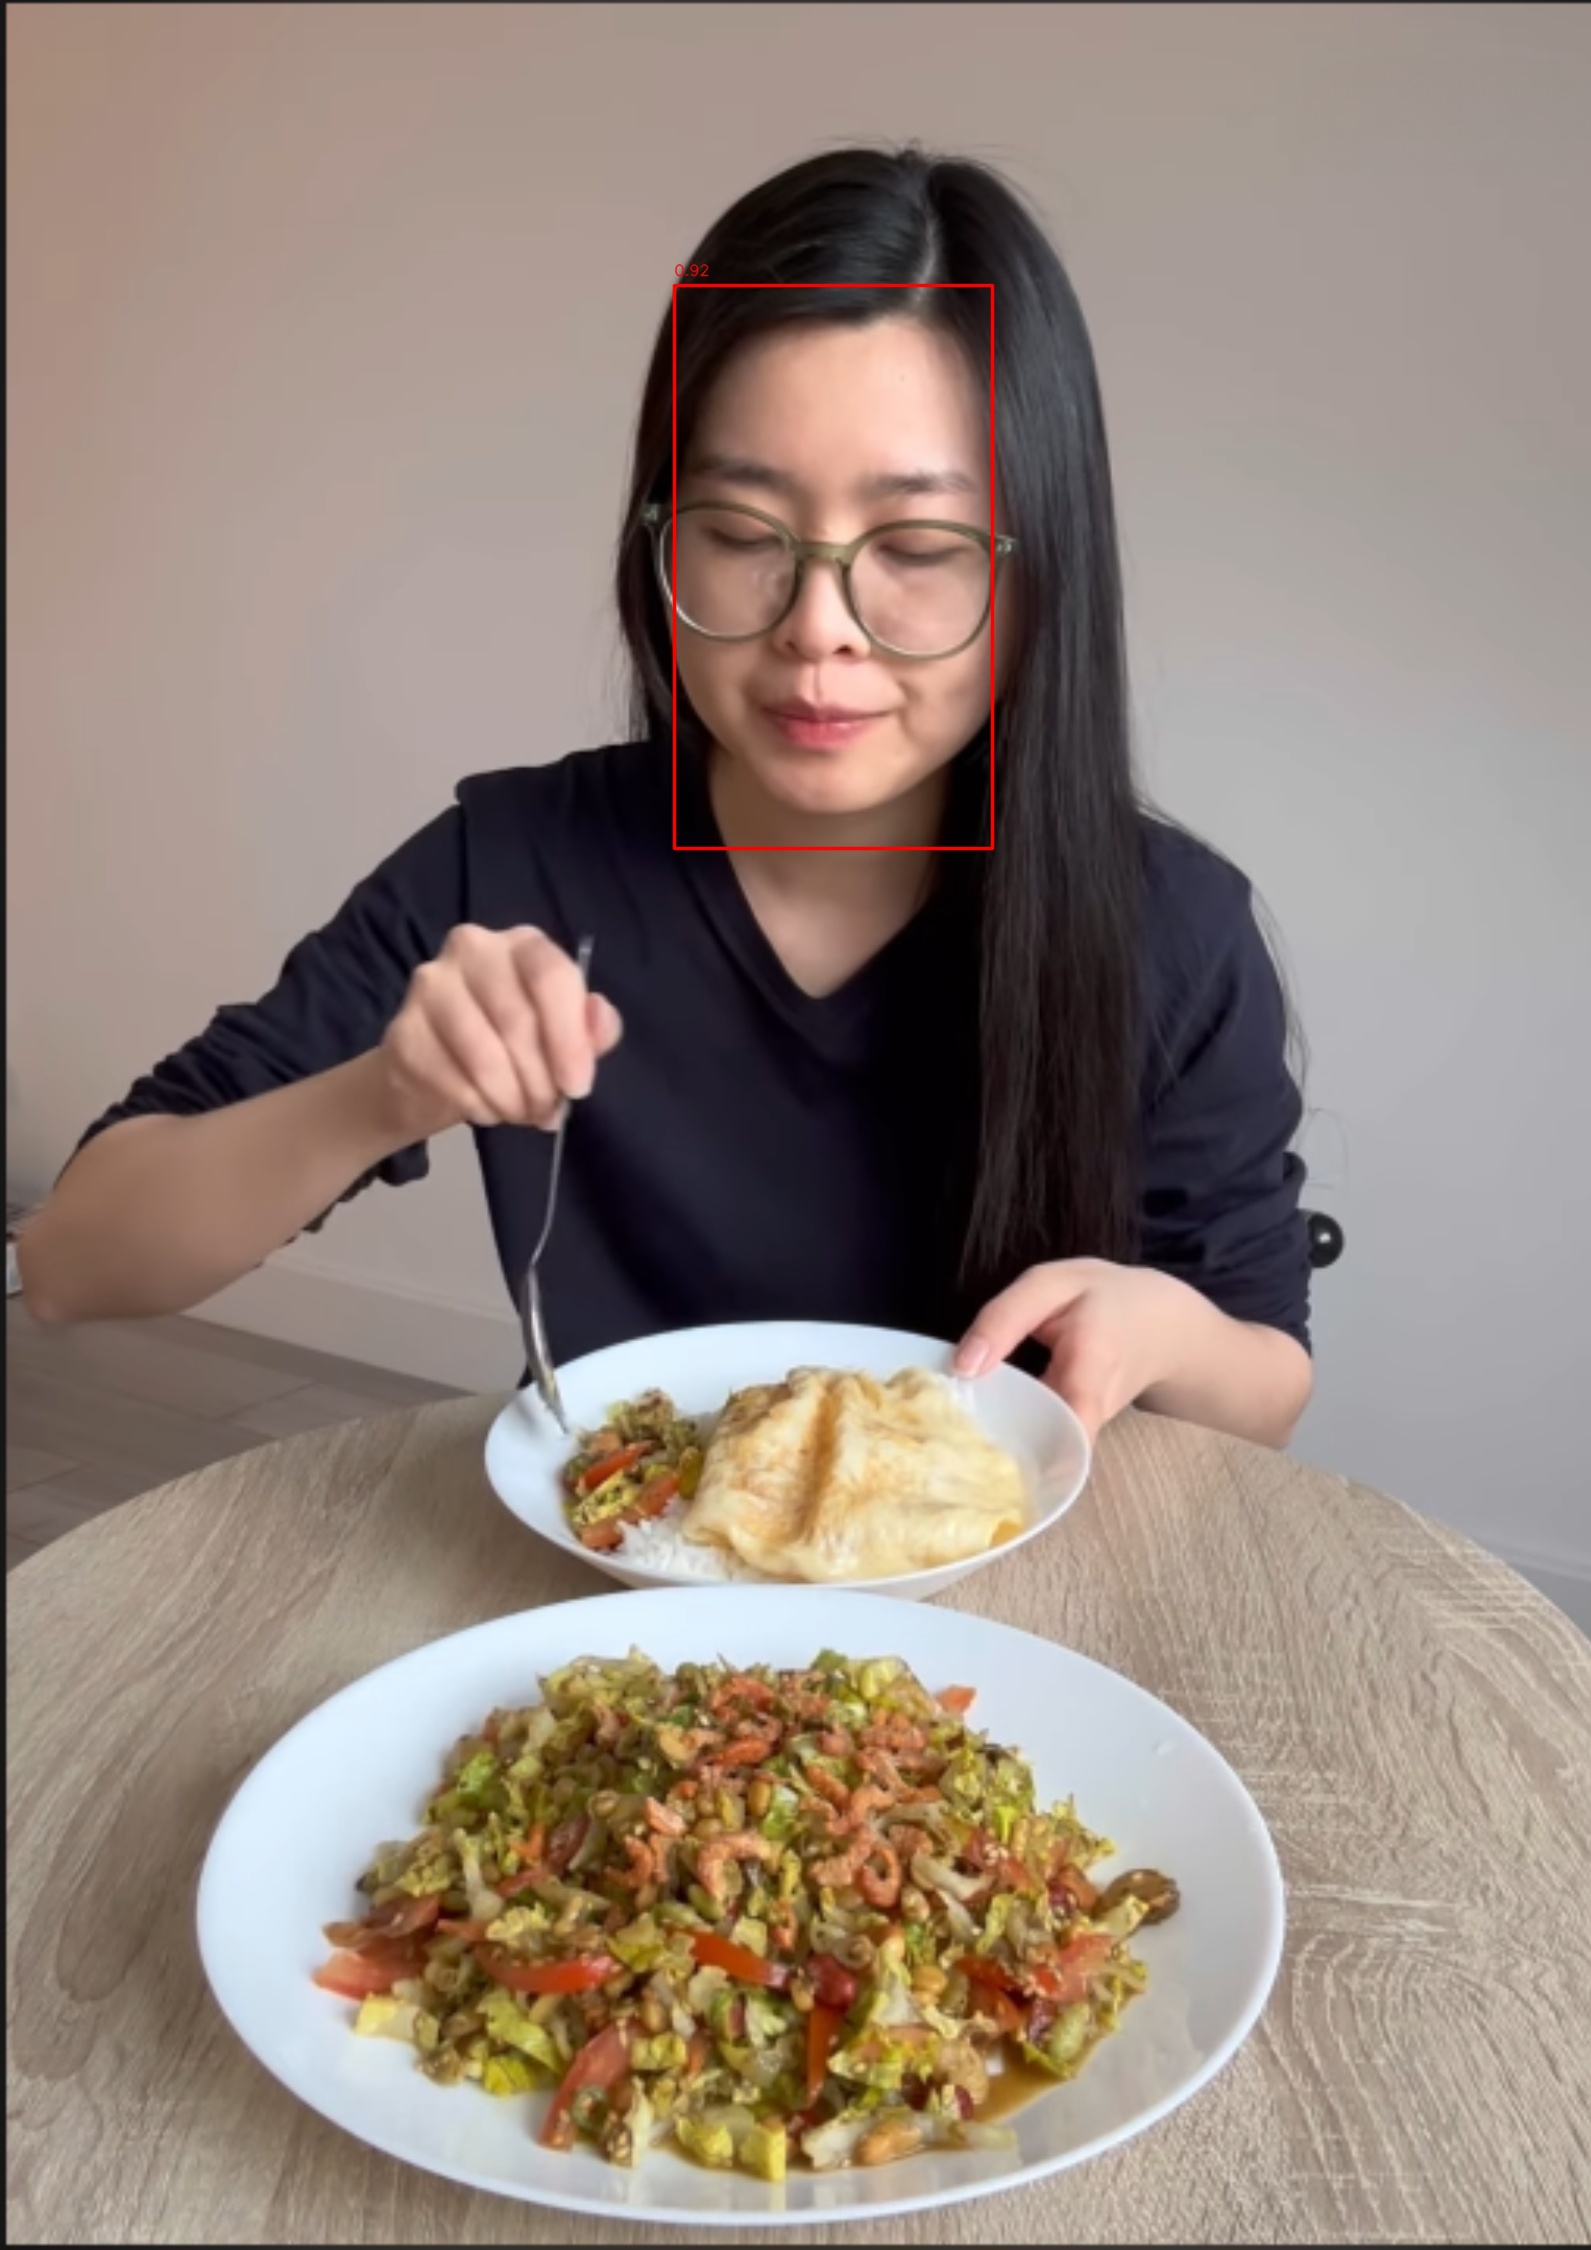

In [ ]:
fd = FaceDetectorYunet()
show_drawn_face = True

# read image and detect faces
img = cv2.imread(image_path)
faces = fd.detect(img)
face_centers = [((face['x1']+face['x2'])/2, (face['y1']+face['y2'])/2) for face in faces]

input_point = np.array(face_centers)
input_label = np.ones(len(input_point))

if show_drawn_face:
    # draw rectangle on faces
    if faces:
      fd.draw_faces(img, faces, show_confidence=True)

    # show image
    _, ret = cv2.imencode('.jpg', img)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

### [Option 2] Manual Face Selection

Manually select the object to be masked by clicking on it. The `(x, y)` coordinate of the clicked point will be recorded. The more the points provided for the object, the less ambiguous the model is in determining the objects of your interest.

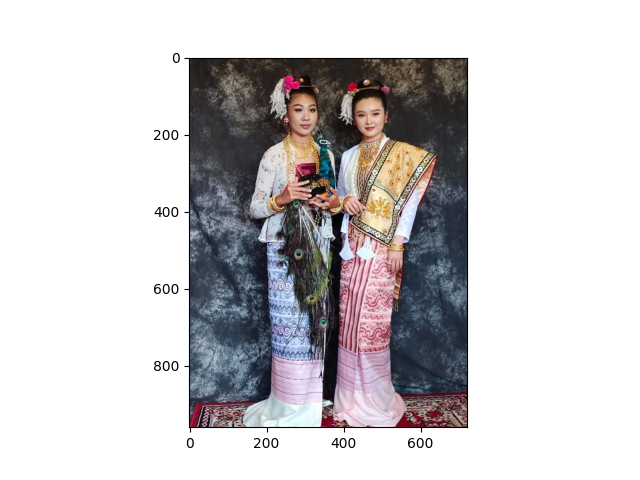

xdata=304.954545, ydata=164.175325
xdata=478.980519, ydata=140.798701
xdata=263.396104, ydata=351.188312
xdata=429.629870, ydata=382.357143
xdata=538.720779, ydata=514.824675
xdata=369.889610, ydata=371.967532


In [27]:
%matplotlib widget

if IN_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

fig, ax = plt.subplots()
ax.imshow(image)
plt.show()

coordinates = list()

def onclick(event):
    print('xdata=%f, ydata=%f' % (event.xdata, event.ydata))
    coordinates.append((event.xdata, event.ydata))

cid = fig.canvas.mpl_connect('button_press_event', onclick)

Record the coordinates.

In [28]:
input_point = np.array(coordinates)
input_label = np.ones(len(input_point))

## Segmenting based on Selected Points

The three masks generated at the first iteration may not align with your interest. But, select the mask that you like the most (`1`, `2`, or `3`) because the selected mask can be used as an argument for the mask-generation function call at the next iteration to aid in prediction. Iteratively, the masks will become better suited to your interest. When you're satisfied, select your final mask and quit by typing `n`.

===================Round 1===================
Generating masks....


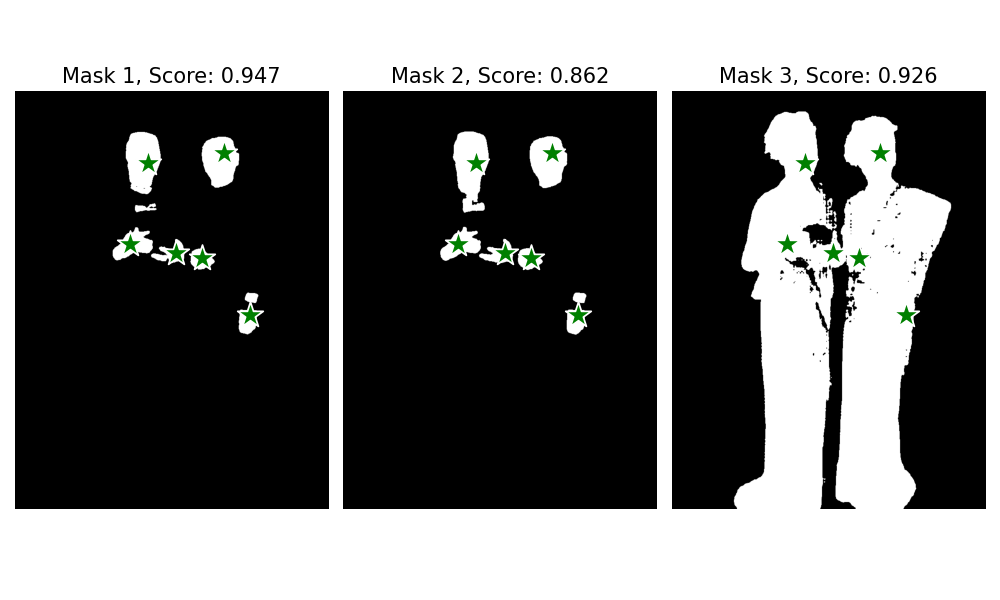

Which mask do you like best? (1/2/3): 1
Do you want to iterate another round? (y/n): n
Mask 1 at round 1 is selected!
The following figure shows the final mask selected.
The mask saved to images/masks/Myanmar_clothes_12_mask.png


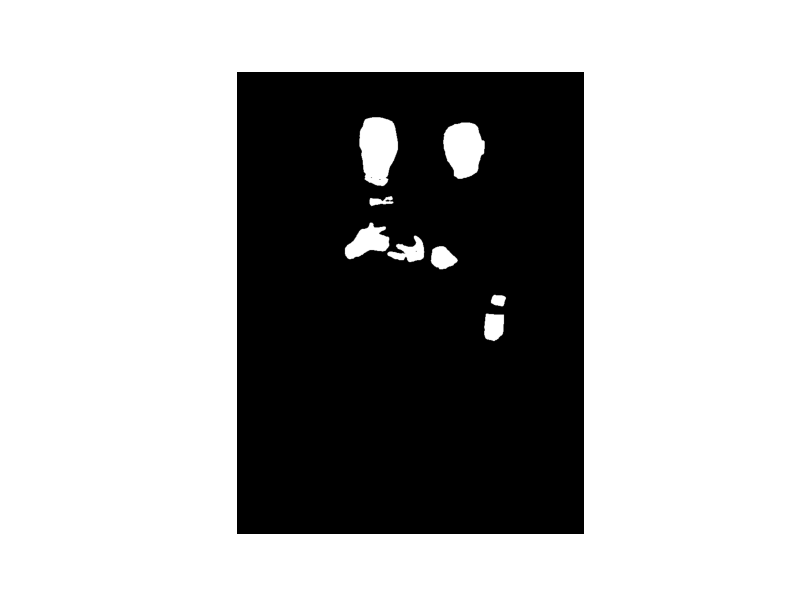

In [29]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)


counter, logits, preferred_mask_index, preferred_masks = 0, None, 0, None

while True:
  ### Generate masks  ###
  print(f"===================Round {counter+1}===================")
  print(f"Generating masks....")
  if counter == 0:
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
  else:
    mask_input = logits[preferred_mask_index, :, :]  # Choose the model's best mask

    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        mask_input=mask_input[None, :, :],
        multimask_output=True,
    )

  ### Plot masks ###
  fig, axes = plt.subplots(1, len(masks), figsize=(10, 6))  # Create subplots for side-by-side display
  for i, (mask, score) in enumerate(zip(masks, scores)):
      ax = axes[i]  # Select the appropriate subplot
      ax.imshow(image)  # Display the original image
      show_mask(mask, ax)  # Overlay the mask
      show_points(input_point, input_label, ax)  # Overlay the points
      ax.set_title(f"Mask {i+1}, Score: {score:.3f}", fontsize=15)  # Add a title
      ax.axis('off')  # Turn off the axes

  plt.tight_layout()  # Adjust layout to prevent overlap
  plt.show()

  ### Request user input ###
  mask_preference = int(input(f"Which mask do you like best? (1/2/3): "))
  assert mask_preference in range(3), "Select either mask 1 [index 0], mask 2 [index 1], or mask3 [index 2]"

  preferred_mask_index = mask_preference - 1

  continue_preference = input("Do you want to iterate another round? (y/n): ").lower()
  assert continue_preference in ['y', 'n'], "Select either 'y' or 'n'"

  if continue_preference == 'n':
    print(f"Mask {preferred_mask_index+1} at round {counter+1} is selected!")
    preferred_masks = masks[preferred_mask_index, :, :]
    break
  elif continue_preference == 'y':
    counter += 1
    continue

### Show the selected final mask
print("The following figure shows the final mask selected.")
plt.figure(figsize=(8,6), clear=True)
plt.imshow(image)
show_mask(preferred_masks, plt.gca())
plt.axis('off')

### Save the mask
image_file_name = os.path.splitext(os.path.basename(image_path))[0] + "_mask.png"

# Create a bytes buffer to save the plot
buf = io.BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight')
buf.seek(0)

# Apply blur kernel to improve inpainting quality
blur = GaussianBlur(11,20)
blurred_mask = blur(Image.open(buf))

# save and show
blurred_mask.save(f'images/masks/{image_file_name}')
print(f"The mask saved to images/masks/{image_file_name}")
plt.show()